# Predicting House Values

## Read Data

In [1]:
import pandas as pd
import os

housing_path = os.path.join("datasets", "housing", "housing.csv")
housing = pd.read_csv(housing_path)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## A Quick Look into the Data

In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice that the "total_bedrooms" attribute has 207 missing values, and that the "ocean_proximity" attribute is the only attribute with the object type.

In [3]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

We now know that "ocean_proximity" is actually a categorical attribute.

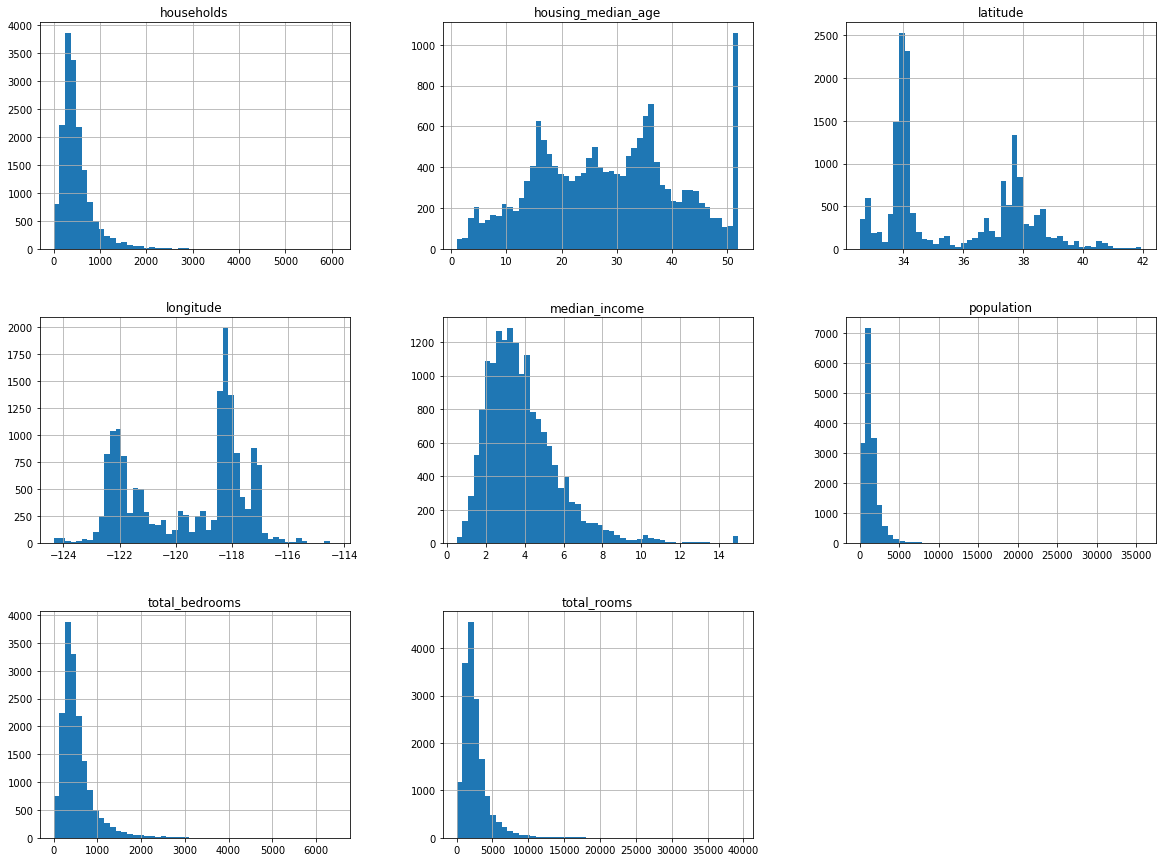

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

housing.hist(bins=50, figsize=(20,15))
plt.show()

Notice that:
1. The "median_income" attribute seems to be scaled and capped at 15.
2. The "housing_median_age" and "median_house_value" attributes are also capped.
3. Attributes have very different scale, and many attributes have right-skewed distributions.

## Split Data into Test and Train Sets

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## Exploratory Data Analysis

In [6]:
housing = train_set.copy()

### Visualization

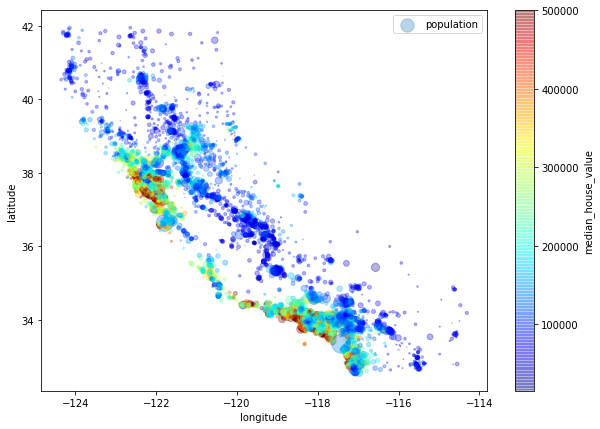

In [7]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

As we can observe, population and location attributes are probably closely related with house values.

### Correlations

In [8]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

Notice that "median_income", "total_rooms" and "housing_median_age" have the strongest correlations with "median_house_value".

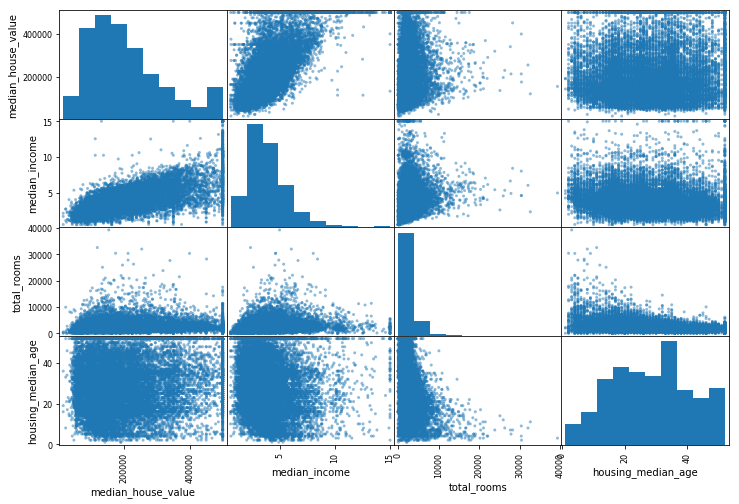

In [9]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

We can see that "median_income" seems to be the most promising attibute to predict house values by far.

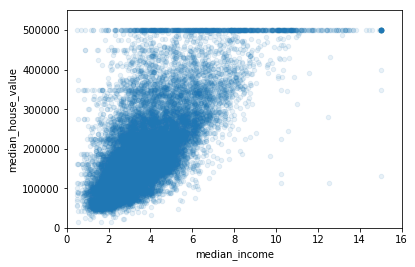

In [10]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

## Feature Engineering

In [11]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

In [12]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.690647
rooms_per_household    0.158485
total_rooms            0.133989
housing_median_age     0.103706
households             0.063714
total_bedrooms         0.047980
population            -0.026032
longitude             -0.046349
latitude              -0.142983
bedrooms_per_room     -0.257419
Name: median_house_value, dtype: float64

By combining the "total_rooms" attribute with "households" and "total_bedrooms", we see that our new attributes "rooms_per_household" and "bedrooms_per_room" are more correlated with the median house values than the original attributes.

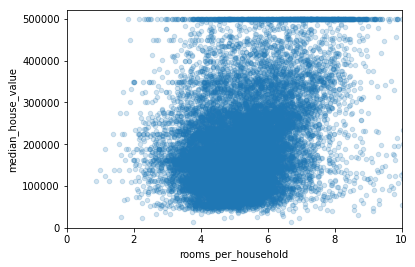

In [13]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 10, 0, 520000])
plt.show()

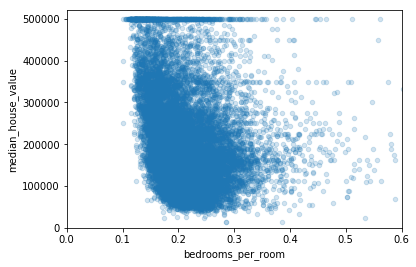

In [14]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.axis([0, 0.6, 0, 520000])
plt.show()

## Data Cleaning and Preparation

In [15]:
#Separate attributes and labels
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

In [16]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

This function adds "rooms_per_household" and "population_per_household" features to the dataset.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #Fill missing values
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)), #Add extra attributes
        ('std_scaler', StandardScaler()), #Standardization
    ])

This pipeline:
1. Fills missing values with median values;
2. Adds extra features as mentioned above;
3. Standardizes numerical attributes.

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs), #One-hot encoding
    ])

In addition to the previous pipeline, this full pipeline encode our categorical attribute "ocean_proximity" into one-hot vectors.

In [19]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

## Test Models

We try out several models and look at their performance on the training set and cross validation sets measured by Root Mean Squred Error (RMSE). The lower the RMSE score is, the better the performance of the model is.

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def calculate_training_score(model):
    model.fit(housing_prepared, housing_labels)
    housing_predictions = model.predict(housing_prepared)
    mse = mean_squared_error(housing_labels, housing_predictions)
    return np.sqrt(mse)

def calculate_cross_val_scores(model):
    mse = cross_val_score(model, housing_prepared, housing_labels, 
                          scoring="neg_mean_squared_error", cv=10)
    rmse = np.sqrt(-mse)
    return rmse

def display_scores(model):
    training_score = calculate_training_score(model)
    cross_val_scores = calculate_cross_val_scores(model)
    print("Training Score:", training_score)
    print("Cross Validation Mean Score:", cross_val_scores.mean())
    print("Standard deviation:", cross_val_scores.std())

In [21]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
display_scores(lin_reg)

Training Score: 67593.20745775253
Cross Validation Mean Score: 67828.38677377408
Standard deviation: 2468.0913950652284


In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
display_scores(tree_reg)

Training Score: 0.0
Cross Validation Mean Score: 68848.18979613911
Standard deviation: 2579.6785558576307


In [23]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
display_scores(forest_reg)

Training Score: 21787.892649206584
Cross Validation Mean Score: 52382.566664265214
Standard deviation: 1874.144245319522


As we can see, the Random Forest Regressor has the best performance among the models tested. However, it is worthy to note that its score on the training set is still much lower than that on the validation sets, meaning that the model is still overfitting the training set.

## Fine-tune Model

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [25]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

## Evaluate Model on Test Set

In [26]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [27]:
final_rmse

49198.020631676336